In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense


from tcn import TCN

# Inverting representations

This section introduces the computation of an approximate
inverse of a time series representation. This is formulated
as the problem of finding a time series whose representation
best matches the one given.

## I/ Representation to be inverted

### 1/ The original time-serie

In [2]:
df = pd.read_csv('all_stocks_5yr.csv', delimiter=',', usecols=['date', 'close', "Name"])
df_AAPL = df.query("Name == 'AAPL'")
df_AAPL.head(-1)

,date,close,Name
1259,2013-02-08,67.8542,AAPL
1260,2013-02-11,68.5614,AAPL
1261,2013-02-12,66.8428,AAPL
1262,2013-02-13,66.7156,AAPL
1263,2013-02-14,66.6556,AAPL
...,...,...,...
2512,2018-01-31,167.4300,AAPL
2513,2018-02-01,167.7800,AAPL
2514,2018-02-02,160.5000,AAPL
2515,2018-02-05,156.4900,AAPL


In [3]:
pd.options.plotting.backend = "plotly"
df_AAPL.plot(x='date', y='close')

In [4]:
close_aapl = df_AAPL['close'].values
ts_size = close_aapl.shape[0]
X_test, y_test = np.array(close_aapl[:ts_size-64]), np.array(close_aapl[ts_size-64:])

### 2/ The representation (TCN)

In [5]:
import tensorflow as tf

In [6]:
i = Input(shape=(ts_size - 64, 1))
m = TCN()(i)
model = Model(inputs=[i], outputs=[m])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1195, 1)]         0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                136256    
Total params: 136,256
Trainable params: 136,256
Non-trainable params: 0
_________________________________________________________________


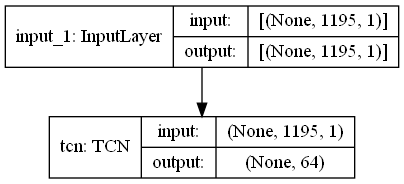

In [7]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### 3/ The representation of the time serie

Depending on the task and type of model we may want to generate a variety of data windows. For examples:

1. For example, to make a single prediction 24 days into the future, given 24 days of history, we might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one day into the future, given six days of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

### 4/ Training the representation

In [8]:
n_company = 505
size_company = 1259

In [9]:
data = df.groupby(['Name'])['close'].agg(list)
data_train = data.drop('AAPL')

In [10]:
data_array = np.array([x for x in data_train if len(x) == size_company])
X_train, y_train = data_array[:, :size_company-64], data_array[:, size_company-64:]

In [11]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [12]:
print('Train...')
history = model.fit(X_train, y_train, epochs=100, verbose=0)

Train...


KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_test.reshape((1, 1195))).reshape(64)

In [ ]:
import matplotlib.pyplot as plt

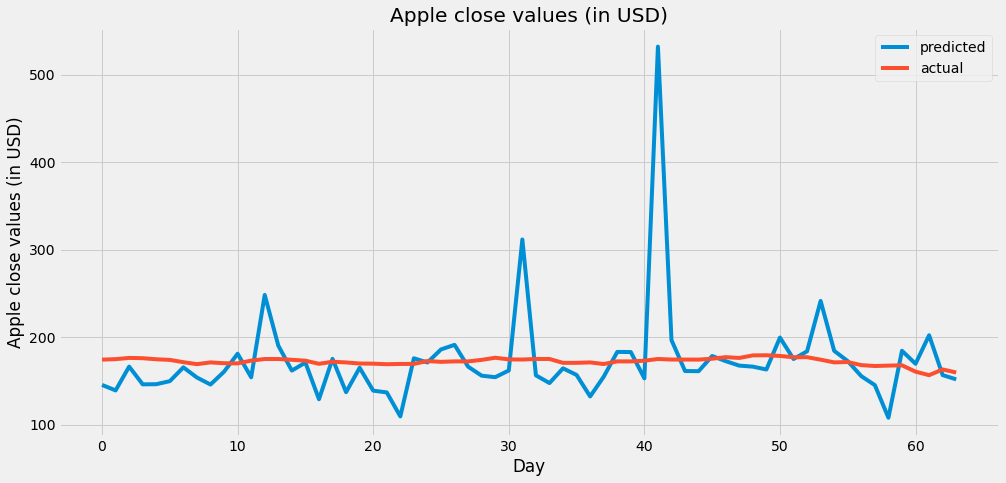

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,7))
plt.plot(y_pred)
plt.plot(y_test)
plt.title('Apple close values (in USD)')
plt.legend(['predicted', 'actual'])
plt.xlabel("Day")
plt.ylabel("Apple close values (in USD)")
plt.show()

### 3/ Loss function

In [ ]:
def loss(preds, target):
    mse = tf.keras.losses.MeanSquaredError()
    return mse(target, preds).numpy()

### 4/ Regulariser

In [ ]:
def regulariser(x, alpha):
    return np.linalg.norm(x, alpha)

## II/ Optimisation